In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
%matplotlib inline

Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [27]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        df['vol'] = df['pct_change'].rolling(252).std()
        tickers[ticker]['vol'] = df['pct_change'].std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    ticker_to_category = pd.DataFrame.from_dict(tickers, orient='index')
    ticker_to_category['category'] = pd.cut(ticker_to_category['vol'], n_categories, labels=range(n_categories))
#     km = KMeans(n_categories)
#     ticker_to_category['category'] = km.fit_predict([[x] for x in ticker_to_category['vol'].values])
    
    combined['category'] = combined['ticker'].apply(lambda x: ticker_to_category.loc[x, 'category'])
    return out, combined
        

In [28]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=22,window=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=22,window=22,center=False).sum()


In [29]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [30]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [31]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
AGG,0.002803,0
LQD,0.004527,0
CEW,0.005264,0
UUP,0.005521,0
EMB,0.006046,0
FXB,0.006071,0
FXE,0.006127,0
FXY,0.006801,0
HYG,0.006936,0


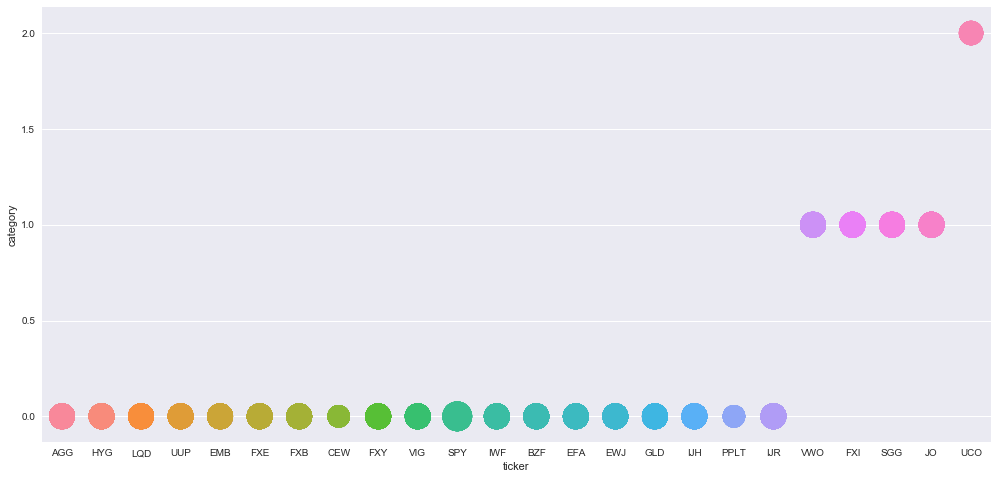

In [32]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined['vol']*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [33]:
combined = combined.dropna()

In [34]:
combined.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,asset_type,category,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,
2001-05-25,60.080002,60.080002,59.150002,59.150002,48.544788,80600,IWF,-0.023669,-0.023953,0.022114,-0.079502,-0.082427,equity,0,0,0,0
2001-05-29,59.049999,59.049999,57.750000,57.750000,47.395802,110000,IWF,-0.028052,-0.028453,0.022144,-0.041146,-0.043893,equity,0,0,0,0
2001-05-30,57.119999,57.320000,56.000000,56.130001,46.066238,70300,IWF,0.007661,0.007632,0.022057,-0.003505,-0.005897,equity,0,0,0,0
2001-05-31,56.299999,57.150002,56.299999,56.560001,46.419163,18400,IWF,0.013967,0.013871,0.022068,-0.012062,-0.014425,equity,0,0,0,0
2001-06-01,56.700001,57.619999,56.619999,57.349998,47.067520,22400,IWF,-0.001569,-0.001571,0.021939,-0.028361,-0.030630,equity,0,0,0,0


In [35]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0])

In [ ]:
prices, combined = build_prices_dfs(tickers, 3)

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map
n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

with pm.Model() as model:
    fast_window = 7
    slow_window = 25
    for ticker in combined['ticker'].unique():
        combined.loc[combined['ticker'] == ticker, 'fast'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()
        
        combined.loc[combined['ticker'] == ticker, 'slow'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
    combined['momentum'] = pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])
    combined = combined.dropna()
    
    a_mom = pm.Normal('a_mom', mu=0, sd=2)
    a_vol = pm.Normal('a_vol', mu=0, sd=5)
    
    b_mu = pm.Normal('b_mu', mu=0, sd=3)
    b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Normal('b_security', mu=b_mu, sd=b_sd, shape=n_categories)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (combined['momentum'].values * a_mom + 
             combined['vol'].values * a_vol +
             b_sec[combined['category_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=combined['month_log_return'].values)
    trace = pm.sample(1000, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=22,window=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=22,window=22,center=False).sum()


In [ ]:
pm.traceplot(trace);

In [24]:
def calc_prediction_helper(row):
    rt = row.momentum * np.mean(trace['a_security'][:, row.security_enc])
#     print("{} = {} * {} + {}".format(rt, row.momentum,
#                                      np.mean(trace['a_security'][:, row.security_enc]),
#                                     np.mean(trace['b_security'][:, row.security_enc])))
    a = (row.momentum * trace['a_security'][:, row.security_enc] + trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [25]:
combined['prediction'] = combined.apply(calc_prediction_helper, axis=1)

KeyError: ('a_security', 'occurred at index 2001-05-25 00:00:00')

In [26]:
combined['rounded_prediction'] = combined['prediction'].round(2)
sns.jointplot(combined.groupby('rounded_prediction').mean()['month_log_return'].index, combined.groupby('rounded_prediction').mean()['month_log_return'])

KeyError: 'prediction'

In [19]:
print('Avg. return on long positions: {}'.format(combined.loc[combined.prediction >= .5, 'month_log_return'].mean()))
print('Avg. return on short positions: {}'.format(combined.loc[combined.prediction < .5, 'month_log_return'].mean()))

Avg. return on long positions: 0.004792693371653924
Avg. return on short positions: -0.0058832518629077495


In [21]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = trace['a_security'][:, i]
    ticker_to_b[t] = trace['b_security'][:, i]

In [22]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(VIG=[0.00477493156081, -3.14630427177, -2.43662753793, -2.23677475886, -1.93677378643, 1.66352802543, 1.66352802543, 0.184304106123, -0.0994772189299, -0.094489871401, -0.282323100243, -0.282323100243, 0.452818052155, -0.546230619141, 0.0650193238061, -0.236978284265, 0.156181883489, 0.671354878123, 0.0483970521002, -0.217657997492, -0.217657997492, 0.302224462226, 0.949987416366, -0.97689952162, -0.203657492764, 2.32951364922, 2.32951364922, -1.73478628751, 1.14592298244, 0.828998360837, -1.24945023859, 0.419337141646, 0.98015348485, 0.362120484929, 0.362120484929, 0.077542573868, 0.201186435546, -0.257987978701, -0.257987978701, 0.206371074984, -0.97940716779, -0.0309044854437, -0.0357484680788, 0.154287670126, 0.809629969381, 0.557755373647, 0.246443630457, -0.177363991073, -0.109653536485, 0.0772386043789, -1.52721690022, -1.17629252108, 0.0994811487945, -0.15063219103, 0.649463215054, -0.205051159903, -0.205051159903, 0.0902112320905, 0.356407100146, 0.501838215628, 0.7045200

In [23]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(VIG=[-0.00277044763611, -0.0615264270307, -0.0710817465547, -0.05383775532, -0.0260143165089, 0.0109298858029, 0.0109298858029, -0.0280187247413, -0.0166686853869, -0.00996703157103, 0.0354432307127, 0.0354432307127, 0.0297825554893, 0.00621752976921, 0.0148914569022, -0.00173953773894, -0.00777338592748, 0.0300460483036, 0.00995400533102, 0.00456896936354, 0.00456896936354, 0.0318823596641, -0.00576185714855, 0.016560010081, 0.0173049765455, -0.0489268963625, -0.0489268963625, 0.00366190989717, -0.0091544019151, -0.00527256632697, 0.0130643268981, 0.00120264476854, 0.00337950208584, 0.00364034285584, 0.00364034285584, 0.0291094734939, -0.0174697003287, 0.0255562047891, 0.0255562047891, 0.00878880869572, 0.00736327226955, 0.00772597903135, 0.0114838726001, -0.0169957967694, -0.0103197248927, 0.0117542314888, 0.00667026118224, 0.00695055111212, -0.0346335373297, -0.0128208096814, 0.00361417974998, 0.00414172783197, -7.35775072349e-05, 0.0105352702032, 0.00103121863381, 4.4559110354

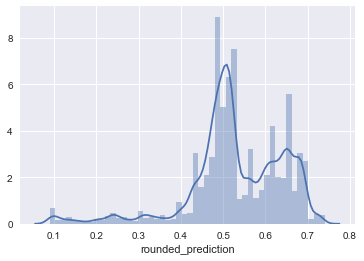

In [450]:
sns.distplot(combined['rounded_prediction'])
# sns.distplot(combined['month_log_return'])

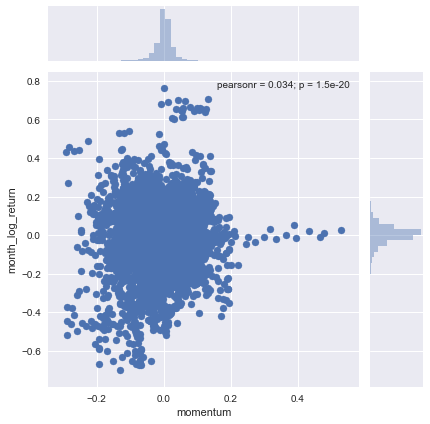

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

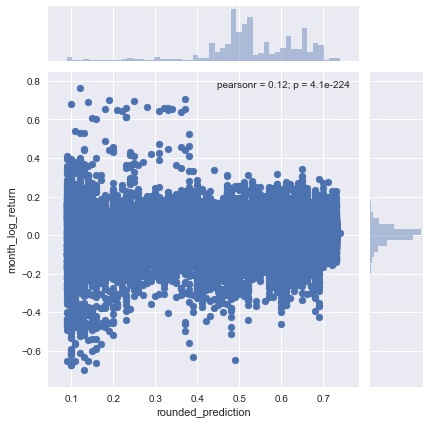

In [452]:
sns.jointplot('rounded_prediction', 'month_log_return', data=combined)

In [1]:
combined['position'] = 0
combined['position'] = np.where(combined['prediction'] >= .5, 1, 0)
combined['position'] = np.where(combined['prediction'] < .5, -1, 0)
combined['bt_return'] = combined['log_return'] * combined['position']
combined['date'] = combined.index

NameError: name 'combined' is not defined

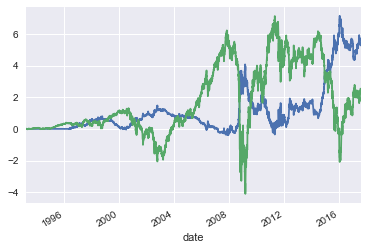

In [454]:
combined.groupby('date').sum()['bt_return'].cumsum().plot()
combined.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

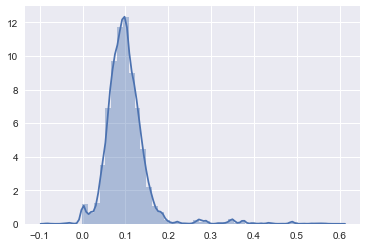

In [319]:
sns.distplot(trace['a_security'][:, 10])

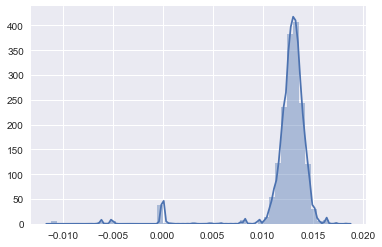

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
